In [1]:
# load some libraries
import sys
import os
import pickle
import gzip
sys.path.insert(1, '..')
os.chdir('..')

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import darts
from darts import metrics

from lib.gluformer.model import *
from lib.latent_ode.trainer_glunet import *
from utils.darts_processing import *
from utils.darts_dataset import *

In [ ]:
# load forecasts
with gzip.open('./paper_results/data/compressed_forecasts.pkl', 'rb') as file:
    save_forecasts = pickle.load(file)
# load true values
with gzip.open('./paper_results/data/compressed_trues.pkl', 'rb') as file:
    save_trues = pickle.load(file)

# compute day and night errors
day_errors = {}
night_errors = {}
datasets = ['weinstock', 'dubosson', 'colas', 'iglu', 'hall']
models = ['gluformer', 'latentode', 'tft', 'nhits', 'linreg', 'xgboost', 'transformer']
for dataset in datasets:
    for model in models:
        # initialize errors
        day_errors[f'{model}_{dataset}'] = []
        night_errors[f'{model}_{dataset}'] = []
        # get forecasts
        forecasts = save_forecasts[f'{model}_{dataset}']
        # get true values
        trues = save_trues[f'{model}_{dataset}']
        # compute errors
        if model in ['xgboost', 'linreg']:
            for i, fs in enumerate(forecasts):
                t = trues[i]
                for f in fs:
                    hour = f.start_time().hour
                    error = metrics.mae(f, t)
                    if hour >= 9 and hour < 21:
                        day_errors[f'{model}_{dataset}'].append(error)
                    else:
                        night_errors[f'{model}_{dataset}'].append(error)
        elif model in ['tft', 'nhits', 'transformer']:
            for i, f in enumerate(forecasts):
                # extract true value and hour
                t = trues[i]
                hour = t.start_time().hour
                # compute error
                error = metrics.mae(f, t)
                if hour >= 9 and hour < 21:
                    day_errors[f'{model}_{dataset}'].append(error)
                else:
                    night_errors[f'{model}_{dataset}'].append(error)
        else:
            for i, t in enumerate(trues):
                # extract hour and true as array
                hour = t.start_time().hour
                t = t.values().squeeze()
                # get the forecast
                if model == 'gluformer':
                    f = np.mean(forecasts[i, :, :], axis=1)
                elif model == 'latentode':
                    f = np.mean(forecasts[:, i, :, 0], axis=0)
                # compute error
                error = np.mean(np.abs(f - t))
                if hour >= 9 and hour < 21:
                    day_errors[f'{model}_{dataset}'].append(error)  
                else:
                    night_errors[f'{model}_{dataset}'].append(error)                

In [2]:
# save day and night errors
# with gzip.open('./paper_results/data/compressed_day_errors.pkl', 'wb') as file:
#     pickle.dump(day_errors, file)
# with gzip.open('./paper_results/data/compressed_night_errors.pkl', 'wb') as file:
#     pickle.dump(night_errors, file)

# load day and night errors
with gzip.open('./paper_results/data/compressed_day_errors.pkl', 'rb') as file:
    day_errors = pickle.load(file)
with gzip.open('./paper_results/data/compressed_night_errors.pkl', 'rb') as file:
    night_errors = pickle.load(file)

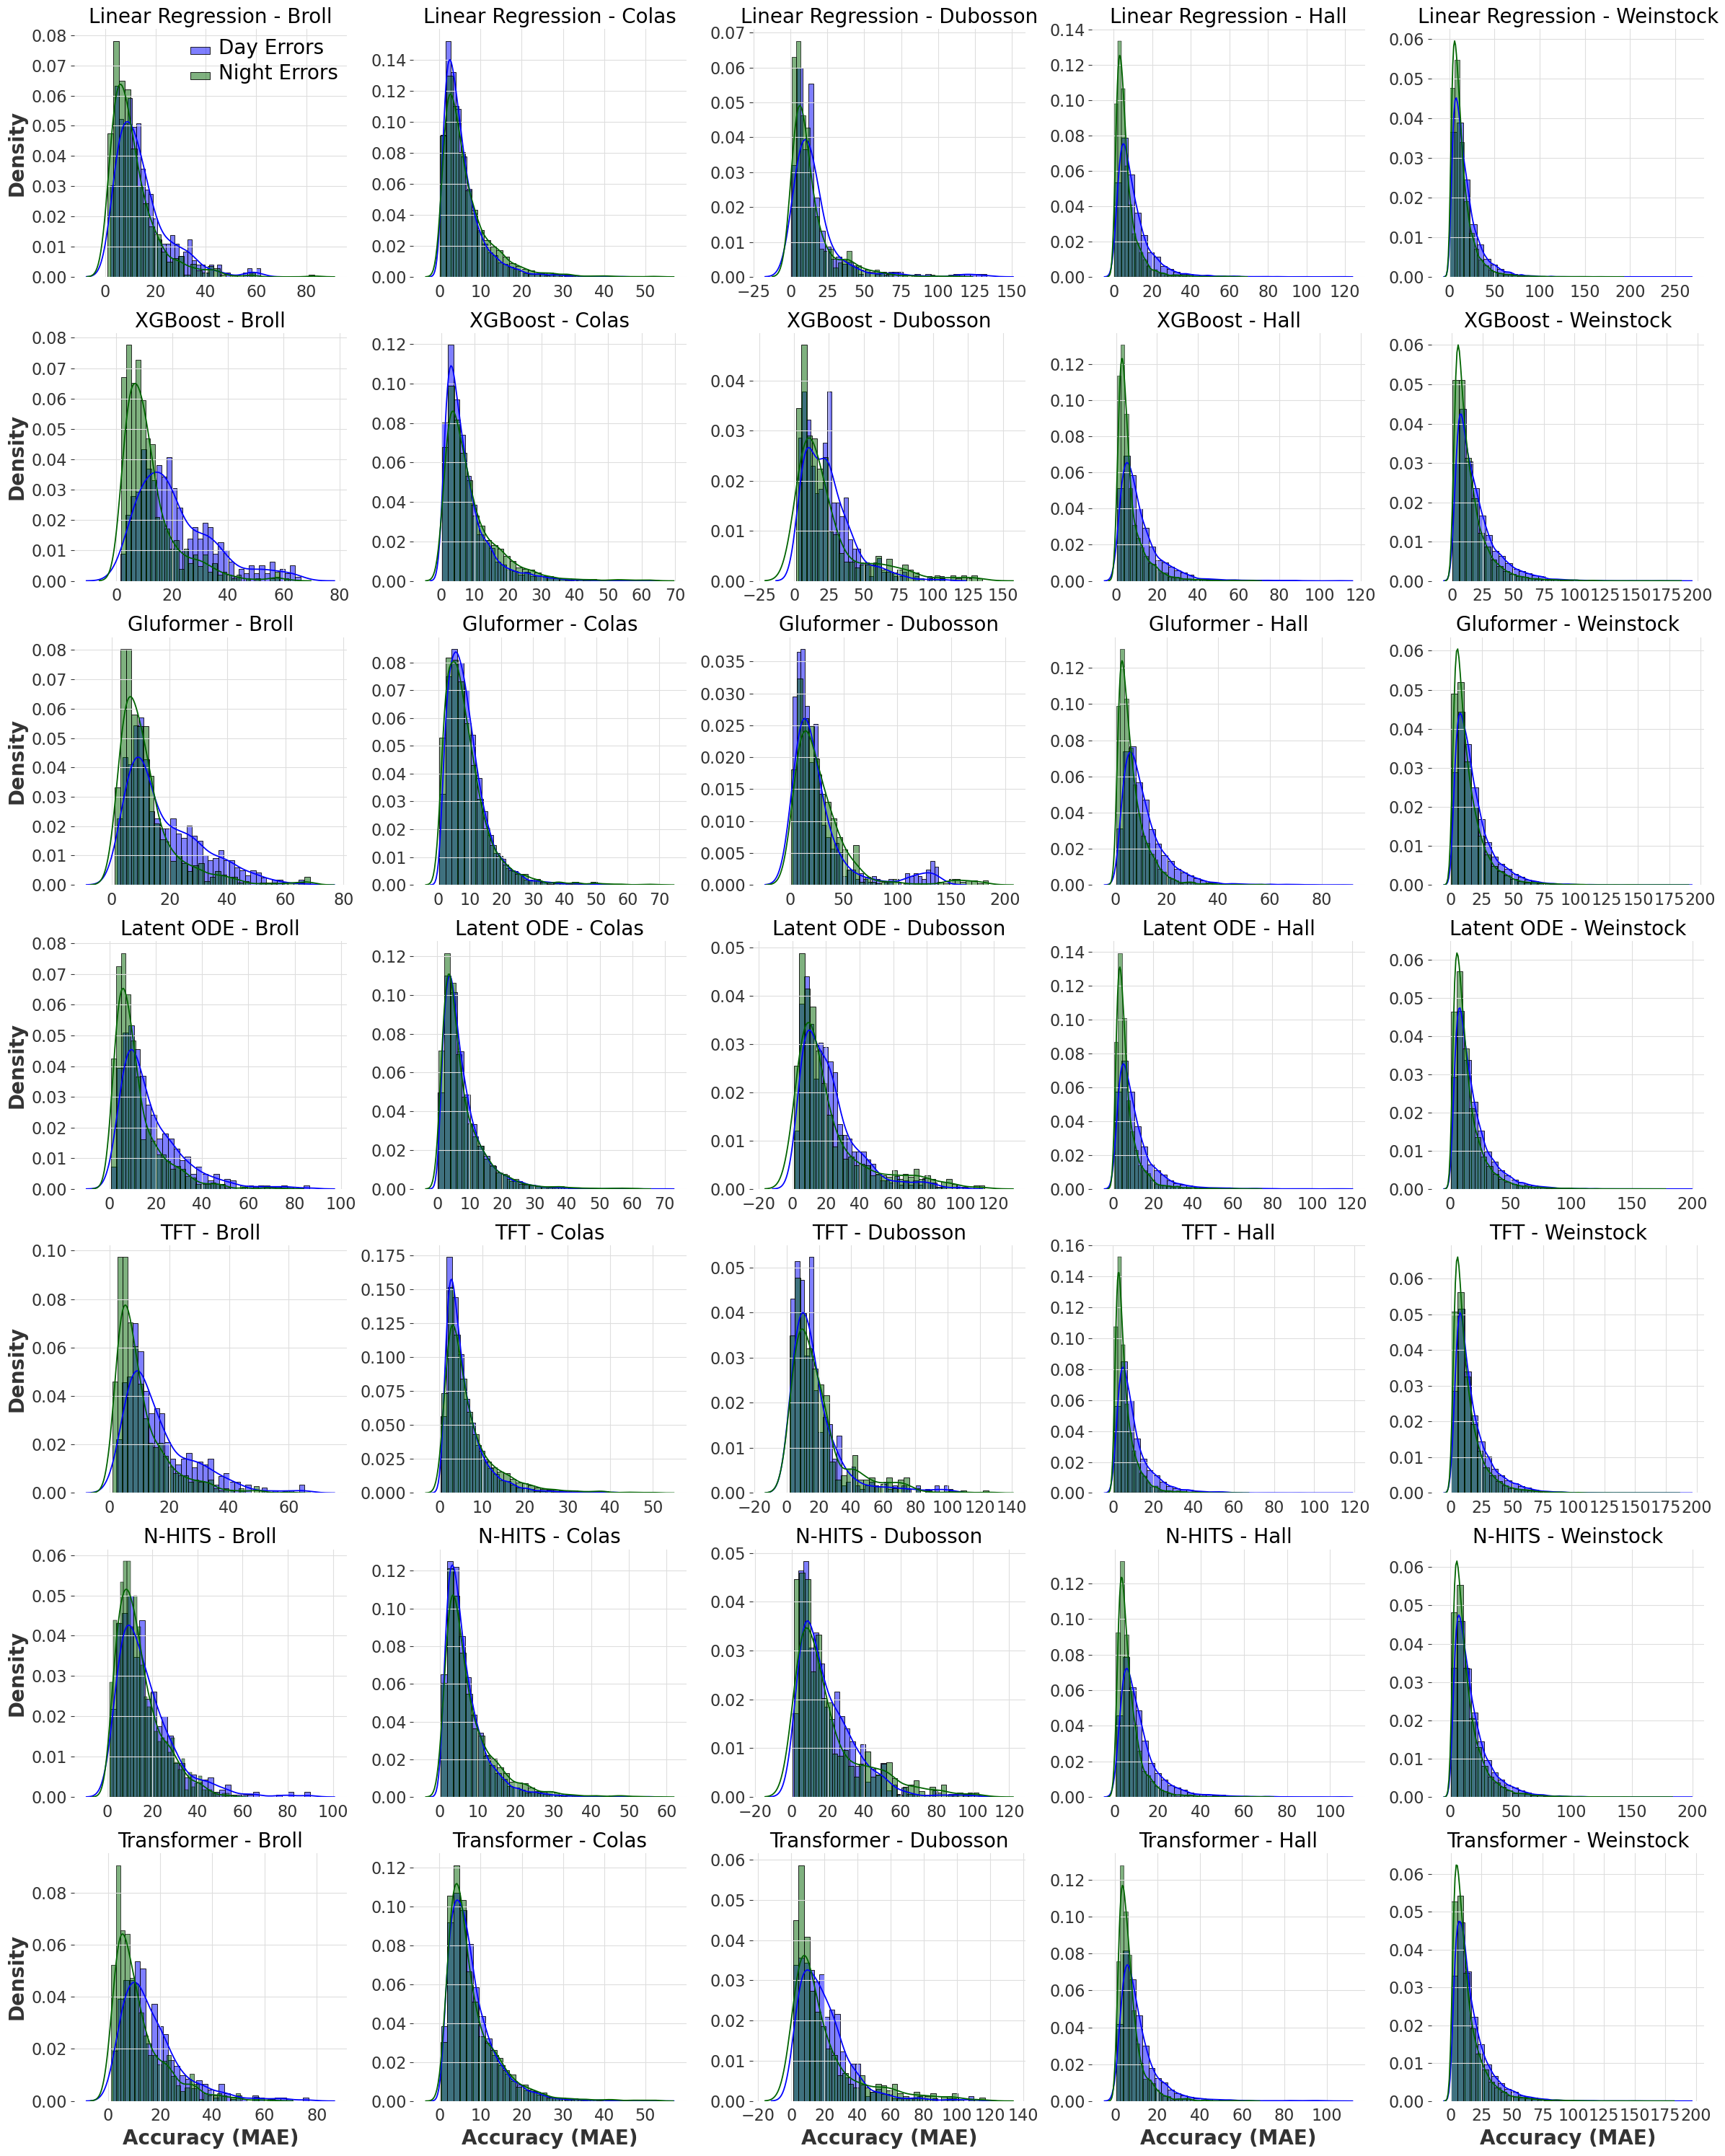

In [11]:
# plot density and normalized histogram of day / night errors for all models and datasets
datasets = ['iglu', 'colas', 'dubosson', 'hall', 'weinstock']
models = ['linreg', 'xgboost', 'gluformer', 'latentode', 'tft', 'nhits', 'transformer']
fig, axs = plt.subplots(len(models), len(datasets), figsize=(24, 30))
model_names = {'gluformer': 'Gluformer', 
               'latentode': 'Latent ODE', 
               'tft': 'TFT', 
               'nhits': 'N-HITS', 
               'linreg': 'Linear Regression', 
               'xgboost': 'XGBoost', 
               'transformer': 'Transformer'} 
dataset_names = {'iglu': 'Broll',
                 'weinstock': 'Weinstock',
                 'dubosson': 'Dubosson', 
                 'colas': 'Colas', 
                 'hall': 'Hall'}
for i, model in enumerate(models):
        for j, dataset in enumerate(datasets):
                ax = axs[i, j]
                day_errors_list = day_errors[f'{model}_{dataset}']
                night_errors_list = night_errors[f'{model}_{dataset}']
                # plot normalized histogram with 50 bins
                sns.histplot(day_errors_list, stat='density', alpha=0.5, 
                        color='blue', label='Day Errors', ax=ax, bins=35)
                sns.histplot(night_errors_list, stat='density', alpha=0.5, 
                        color='darkgreen', label='Night Errors', ax=ax, bins=35)
                # Plot density estimates of the two lists of values
                sns.kdeplot(day_errors_list, color='blue', linestyle='-', ax=ax)
                sns.kdeplot(night_errors_list, color='darkgreen', linestyle='-', ax=ax)
                # Add legend
                ax.legend()
                # set y label for first column
                if j == 0:
                        ax.set_ylabel('Density')
                else:
                        ax.set_ylabel('')
                # set x label for last row
                if i == len(models) - 1:
                        ax.set_xlabel('Accuracy (MAE)')
                else:
                        ax.set_xlabel('')
                # set title
                ax.set_title(f'{model_names[model]} - {dataset_names[dataset]}')
                # add legend to first plot
                if i == 0 and j == 0:
                        ax.legend()
                else: 
                        ax.get_legend().remove()

for ax in axs.flatten():
        for item in [ax.xaxis.label, ax.yaxis.label, ax.title]:
                item.set_fontsize(20)
        for item in ax.get_xticklabels() + ax.get_yticklabels():
                item.set_fontsize(16)
        if ax.get_legend() is not None:
                for item in ax.get_legend().get_texts():
                        item.set_fontsize(20)
        # increase title font size
        
# save as pdf
plt.tight_layout()
plt.savefig("./paper_results/plots/figure5.pdf")